In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

Using device: cpu


In [13]:
# Load datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [14]:
# Simple MLP Network
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        # CIFAR-10 images are 32x32x3 = 3072 pixels
        self.flatten = nn.Flatten()
        
        # Define your layers here - experiment with these!
        self.layers = nn.Sequential(
            nn.Linear(3072, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(2048, 1054),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(1054, 512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(256, 10)       # Output layer: 128 -> 10 classes
        )
    
    def forward(self, x):
        x = self.flatten(x)  # Convert 32x32x3 image to 3072-length vector
        x = self.layers(x)
        return x

In [15]:
# Initialize model
model = SimpleMLP().to(device)
print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Model has 9127208 parameters


In [16]:
# Training function with test accuracy tracking
def train_model(epochs=10):
    model.train()
    train_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Print progress and test every 200 steps
            if i % 200 == 199:
                avg_loss = running_loss/200
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}], Loss: {avg_loss:.4f}')
                train_losses.append(avg_loss)
                
                # Test accuracy at this point
                test_acc = quick_test()
                test_accuracies.append(test_acc)
                print(f'Current Test Accuracy: {test_acc:.2f}%')
                
                running_loss = 0.0
                model.train()  # Make sure we're back in training mode
    
    return train_losses, test_accuracies

In [17]:
# Quick test function for during training
def quick_test():
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total

In [18]:
# Detailed test function
def test_model():
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    print(f'Overall Test Accuracy: {100 * correct / total:.2f}%')
    
    # Print per-class accuracy
    for i in range(10):
        if class_total[i] > 0:
            print(f'{classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

In [19]:
# Visualize some samples
def show_samples():
    dataiter = iter(trainloader)
    images, labels = next(dataiter)
    
    # Show first 8 images
    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    for i in range(8):
        img = images[i]
        # Denormalize for display
        img = img * 0.5 + 0.5
        img = np.transpose(img, (1, 2, 0))
        
        axes[i//4, i%4].imshow(img)
        axes[i//4, i%4].set_title(f'Label: {classes[labels[i]]}')
        axes[i//4, i%4].axis('off')
    
    plt.tight_layout()
    plt.show()


Showing sample images...


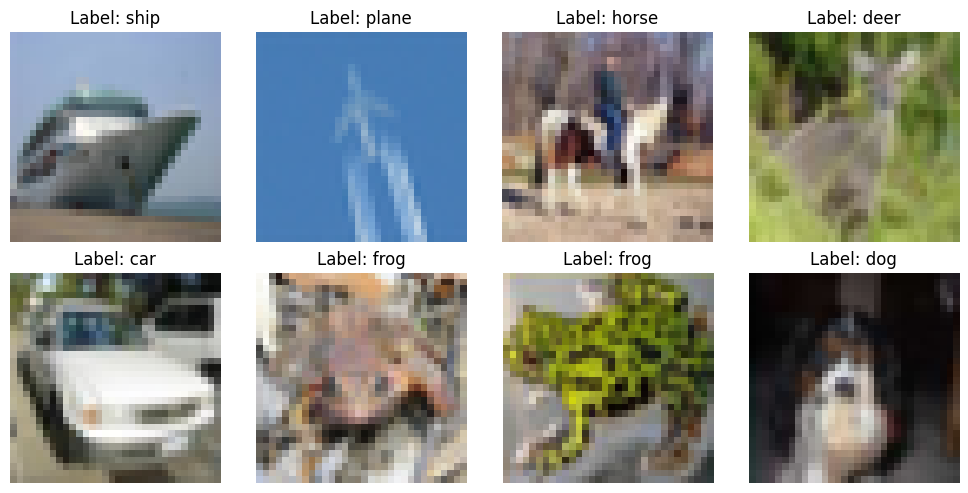


Starting training...
Epoch [1/15], Step [200], Loss: 1.9121
Current Test Accuracy: 35.63%
Epoch [1/15], Step [400], Loss: 1.7848
Current Test Accuracy: 39.97%
Epoch [1/15], Step [600], Loss: 1.7237
Current Test Accuracy: 42.24%
Epoch [2/15], Step [200], Loss: 1.6340
Current Test Accuracy: 44.77%
Epoch [2/15], Step [400], Loss: 1.6051
Current Test Accuracy: 45.44%
Epoch [2/15], Step [600], Loss: 1.5836
Current Test Accuracy: 45.17%
Epoch [3/15], Step [200], Loss: 1.5253
Current Test Accuracy: 46.57%
Epoch [3/15], Step [400], Loss: 1.5343
Current Test Accuracy: 47.03%
Epoch [3/15], Step [600], Loss: 1.5210
Current Test Accuracy: 48.65%
Epoch [4/15], Step [200], Loss: 1.4625
Current Test Accuracy: 47.87%
Epoch [4/15], Step [400], Loss: 1.4725
Current Test Accuracy: 49.46%
Epoch [4/15], Step [600], Loss: 1.4696
Current Test Accuracy: 48.55%
Epoch [5/15], Step [200], Loss: 1.4186
Current Test Accuracy: 50.09%
Epoch [5/15], Step [400], Loss: 1.4246
Current Test Accuracy: 50.28%
Epoch [5/15]

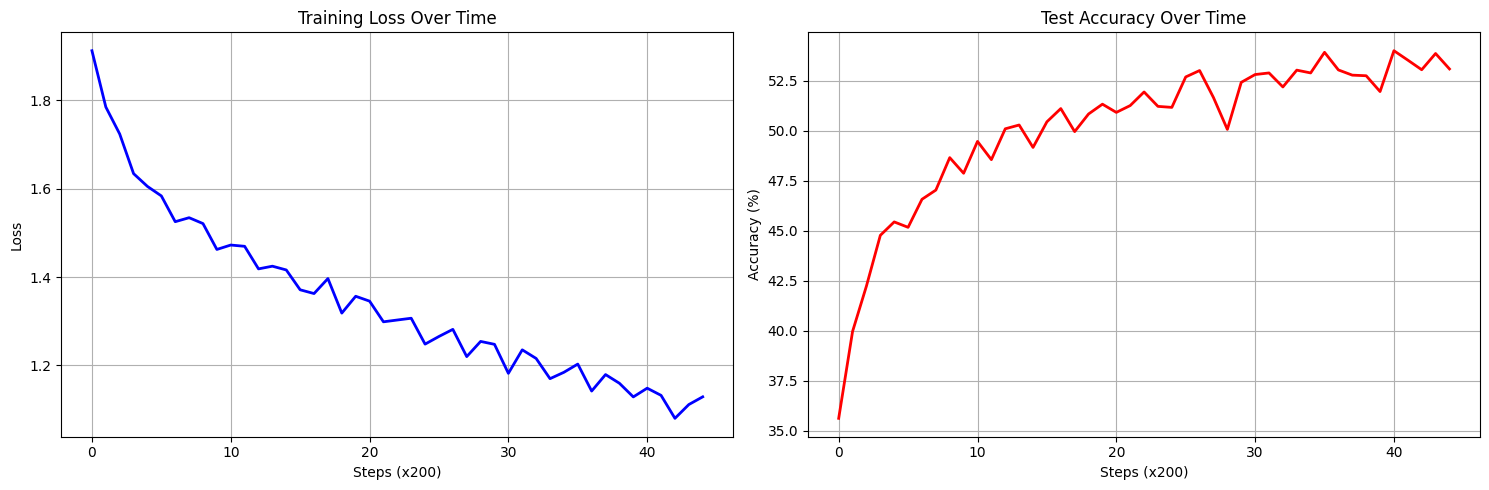

In [ ]:
print("Showing sample images...")
show_samples()

print("\nStarting training...")
losses, accuracies = train_model(epochs=25)

print("\nFinal detailed testing...")
test_model()

# Plot both training loss and test accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 5))

# Training loss
ax1.plot(losses, 'b-', linewidth=2)
ax1.set_title('Training Loss Over Time')
ax1.set_xlabel('Steps (x200)')
ax1.set_ylabel('Loss')
ax1.grid(True)

# Test accuracy
ax2.plot(accuracies, 'r-', linewidth=2)
ax2.set_title('Test Accuracy Over Time')
ax2.set_xlabel('Steps (x200)')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True)

plt.tight_layout()
plt.show()